In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


In [2]:
data = pd.read_csv("../Benchmark/oos_results_regressionNow.csv", sep=";")


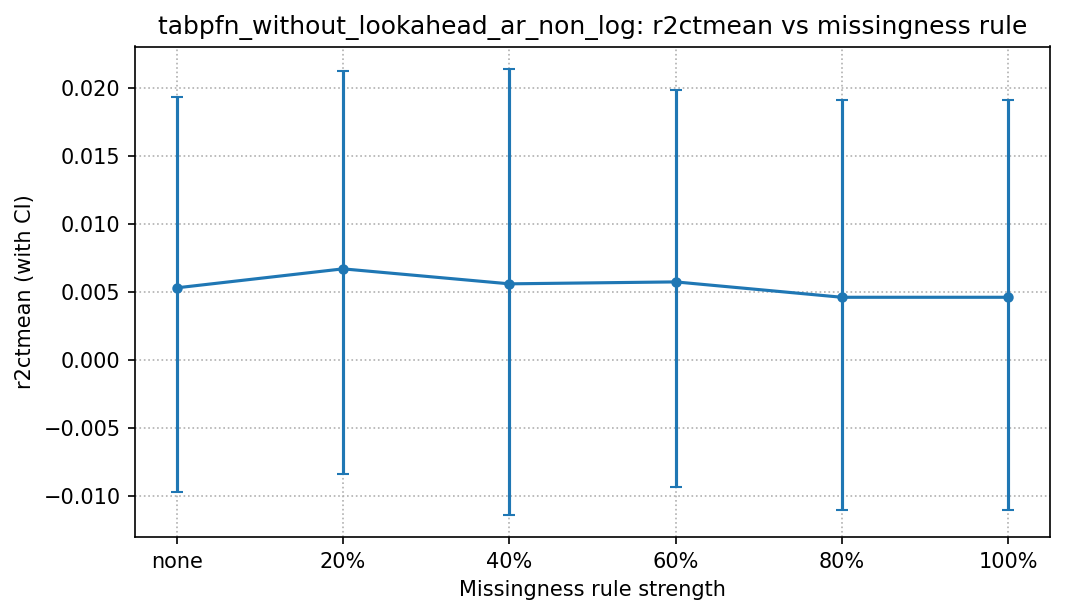

,r2ct,r2,truncated_percent,r2ctmean,r2ctstd,r2ctlower,r2ctupper,r2mean,r2std,r2lower,r2upper,hit_spread,hit_share,rule
model_name,,,,,,,,,,,,,,
tabpfn_without_lookahead_ar_non_log_no_missingness_rule,0.005635,-0.018587,0.263889,0.005287,0.007420,-0.009695,0.019322,-0.019757,0.016115,-0.052507,0.010068,-0.000051,0.736111,NaN
tabpfn_without_lookahead_ar_non_log_02_missingness_rule,0.006941,-0.017827,0.255556,0.006682,0.007615,-0.008356,0.021233,-0.018874,0.015998,-0.052620,0.010772,0.002765,0.744444,0.2
tabpfn_without_lookahead_ar_non_log_04_missingness_rule,0.005965,-0.016606,0.236111,0.005582,0.007947,-0.011382,0.021376,-0.017820,0.015712,-0.049008,0.011751,0.002354,0.763889,0.4
tabpfn_without_lookahead_ar_non_log_06_missingness_rule,0.006148,-0.016877,0.236111,0.005724,0.007463,-0.009354,0.019800,-0.018108,0.015716,-0.050469,0.011404,0.001834,0.763889,0.6
tabpfn_without_lookahead_ar_non_log_08_missingness_rule,0.004975,-0.019046,0.243056,0.004594,0.007448,-0.010994,0.019049,-0.020257,0.016075,-0.053807,0.009540,0.000832,0.756944,0.8
tabpfn_without_lookahead_ar_non_log_10_missingness_rule,0.004975,-0.019046,0.243056,0.004594,0.007448,-0.010994,0.019049,-0.020257,0.016075,-0.053807,0.009540,0.000832,0.756944,1.0


In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt

def plot_tabpfn_missingness_rule(
    df,
    base_prefix="tabpfn_without_lookahead_ar_non_log",
    y_col="r2ctmean",
    lower_col="r2ctlower",
    upper_col="r2ctupper",
    include_baseline=True,          # include "..._no_missingness_rule"
    baseline_label="none",
    savepath_base=None
):
    d = df.copy()

    # ensure index holds model names
    if d.index.name != "model_name" and "model_name" in d.columns:
        d = d.set_index("model_name")

    names = d.index.to_series().astype(str)

    # Keep relevant rows (handle typo "missignness" too)
    mask = (
        names.str.startswith(base_prefix)
        & (names.str.contains("missingness_rule") | names.str.contains("missignness_rule"))
    )
    if include_baseline:
        mask = mask | names.str.fullmatch(re.escape(base_prefix) + r"_no_missingness_rule")

    d = d.loc[mask].copy()
    if d.empty:
        raise ValueError("No TabPFN missingness-rule rows found with the expected naming pattern.")

    # Parse rule strength:
    # - "..._no_missingness_rule" -> NaN (will become baseline label)
    # - "..._02_missignness_rule" -> 0.2, "..._10_..." -> 1.0
    def parse_rule(name: str):
        if name.endswith("_no_missingness_rule"):
            return np.nan
        m = re.search(r"_(\d{2})_(?:missignness|missingness)_rule$", name)
        if not m:
            return None
        return int(m.group(1)) / 10.0  # 02->0.2, 10->1.0

    d["rule"] = [parse_rule(n) for n in d.index]
    d = d[d["rule"].notna() | d.index.to_series().str.endswith("_no_missingness_rule")].copy()

    # Numeric y + CI
    for c in [y_col, lower_col, upper_col]:
        if c not in d.columns:
            raise ValueError(f"Missing column '{c}'.")
        d[c] = d[c].astype(float)

    # Sort: baseline first, then increasing rule
    d["_is_baseline"] = d.index.to_series().str.endswith("_no_missingness_rule")
    d = d.sort_values(["_is_baseline", "rule"], ascending=[False, True])

    # Build categorical x labels
    x_labels = []
    for is_base, r in zip(d["_is_baseline"].to_numpy(), d["rule"].to_numpy()):
        if is_base:
            x_labels.append(baseline_label)
        else:
            x_labels.append(f"{int(round(r*100))}%")  # 0.2->20%

    x = np.arange(len(d))
    y = d[y_col].to_numpy()
    lo = d[lower_col].to_numpy()
    hi = d[upper_col].to_numpy()
    yerr = np.vstack([y - lo, hi - y])

    # Plot
    fig, ax = plt.subplots(figsize=(7.2, 4.2), dpi=150)
    ax.errorbar(x, y, yerr=yerr, fmt="o-", capsize=3, linewidth=1.5, markersize=4)

    ax.set_title(f"{base_prefix}: {y_col} vs missingness rule")
    ax.set_xlabel("Missingness rule strength")
    ax.set_ylabel(f"{y_col} (with CI)")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.grid(True, linestyle=":", linewidth=0.8)

    fig.tight_layout()

    if savepath_base:
        fig.savefig(f"{savepath_base}_tabpfn_missingness_rule.png", bbox_inches="tight")
        fig.savefig(f"{savepath_base}_tabpfn_missingness_rule.pdf", bbox_inches="tight")

    plt.show()
    return d.drop(columns=["_is_baseline"], errors="ignore")


# Example:
plot_tabpfn_missingness_rule(data, savepath_base="tabpfn")
